<a href="https://colab.research.google.com/github/DaiVo20/Question-answering-in-BoolQ/blob/main/Deberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 4.7 MB/s 
     |████████████████████████████████| 596 kB 44.5 MB/s 
     |████████████████████████████████| 895 kB 39.2 MB/s 
     |████████████████████████████████| 61 kB 509 kB/s 
     |████████████████████████████████| 3.3 MB 35.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!pip install datasets

     |████████████████████████████████| 298 kB 5.4 MB/s 
     |████████████████████████████████| 243 kB 35.2 MB/s 
     |████████████████████████████████| 1.1 MB 39.0 MB/s 
     |████████████████████████████████| 132 kB 41.9 MB/s 
     |████████████████████████████████| 160 kB 44.8 MB/s 
     |████████████████████████████████| 271 kB 19.3 MB/s 
     |████████████████████████████████| 192 kB 37.7 MB/s 


In [3]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [4]:
from datasets import load_dataset
dataset = load_dataset('boolq')

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952 [00:00<?, ?B/s]

Using custom data configuration default


  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/6.53M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset boolq downloaded and prepared to /root/.cache/huggingface/datasets/boolq/default/0.1.0/bf0dd57da941c50de94ae3ce3cef7fea48c08f337a4b7aac484e9dddc5aa24e5. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'passage'],
        num_rows: 9427
    })
    validation: Dataset({
        features: ['question', 'answer', 'passage'],
        num_rows: 3270
    })
})

In [6]:
import pandas as pd

train_data = pd.DataFrame(dataset['train'])
dev_data = pd.DataFrame(dataset['validation'])
data = pd.concat([train_data, dev_data], ignore_index=True)

In [7]:
data.head(5)

,question,answer,passage
0,do iran and afghanistan speak the same language,True,"Persian (/ˈpɜːrʒən, -ʃən/), also known by its ..."
1,do good samaritan laws protect those who help ...,True,Good Samaritan laws offer legal protection to ...
2,is windows movie maker part of windows essentials,True,Windows Movie Maker (formerly known as Windows...
3,is confectionary sugar the same as powdered sugar,True,"Powdered sugar, also called confectioners' sug..."
4,is elder scrolls online the same as skyrim,False,As with other games in The Elder Scrolls serie...


In [8]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
dev_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

In [9]:
passages_train = train_data['passage'].values
questions_train = train_data['question'].values
answers_train = train_data['answer'].values.astype(int)

passages_test = test_data['passage'].values
questions_test = test_data['question'].values
answers_test = test_data['answer'].values.astype(int)

passages_dev = dev_data['passage'].values
questions_dev = dev_data['question'].values
answers_dev = dev_data['answer'].values.astype(int)

In [10]:
import random
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, AutoModel

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random.seed(26)
np.random.seed(26)
torch.manual_seed(26)

tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base") 

model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-base")
model.to(DEVICE)

learning_rate = 1e-5
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/474 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/533M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.LayerNorm.bias', 'config', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.bias',

In [11]:
def encode_data(tokenizer, questions, passages, max_length):
    input_ids = []
    attention_masks = []

    for question, passage in zip(questions, passages):
        encoded_data = tokenizer.encode_plus(question, passage, max_length=max_length, pad_to_max_length=True, truncation_strategy="longest_first")
        encoded_pair = encoded_data["input_ids"]
        attention_mask = encoded_data["attention_mask"]

        input_ids.append(encoded_pair)
        attention_masks.append(attention_mask)

    return np.array(input_ids), np.array(attention_masks)

In [12]:
max_seq_length = 256
input_ids_train, attention_masks_train = encode_data(tokenizer, questions_train, passages_train, max_seq_length)
input_ids_dev, attention_masks_dev = encode_data(tokenizer, questions_dev, passages_dev, max_seq_length)
input_ids_test, attention_masks_test = encode_data(tokenizer, questions_test, passages_test, max_seq_length)

train_features = (input_ids_train, attention_masks_train, answers_train)
dev_features = (input_ids_dev, attention_masks_dev, answers_dev)
test_features = (input_ids_test, attention_masks_test, answers_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [13]:
batch_size = 12

train_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in train_features]
dev_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in dev_features]
test_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in test_features]

train_dataset = TensorDataset(*train_features_tensors)
dev_dataset = TensorDataset(*dev_features_tensors)
test_dataset = TensorDataset(*test_features_tensors)

train_sampler = RandomSampler(train_dataset)
dev_sampler = SequentialSampler(dev_dataset)
test_sampler = SequentialSampler(test_dataset)

train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
dev_dataloader = DataLoader(dev_dataset, sampler=dev_sampler, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

In [ ]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [ ]:
from tqdm import tqdm
import time

epochs = 5
grad_acc_steps = 1
train_loss_values = []
dev_acc_values = []

for epoch in tqdm(range(epochs), desc="Epoch"):
    # Training
    start = time.perf_counter()
    epoch_train_loss = 0
    model.train()
    model.zero_grad()

    for step, batch in enumerate(train_dataloader):

        input_ids = batch[0].to(DEVICE)
        attention_masks = batch[1].to(DEVICE)
        labels = batch[2].to(DEVICE)     

        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks, labels=labels)

        loss = outputs[0]
        loss = loss / grad_acc_steps
        epoch_train_loss += loss.item()

        loss.backward()
        
        if (step+1) % grad_acc_steps == 0: # Gradient accumulation is over
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Clipping gradients
            optimizer.step()
            model.zero_grad()

    epoch_train_loss = epoch_train_loss / len(train_dataloader)          
    train_loss_values.append(epoch_train_loss)
    
    # Evaluation
    epoch_dev_accuracy = 0
    model.eval()

    for batch in dev_dataloader:
      
        input_ids = batch[0].to(DEVICE)
        attention_masks = batch[1].to(DEVICE)
        labels = batch[2]

        with torch.no_grad():
            outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks)
                        
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        
        predictions = np.argmax(logits, axis=1).flatten()
        labels = labels.numpy().flatten()
        
        epoch_dev_accuracy += np.sum(predictions == labels) / len(labels)

    epoch_dev_accuracy = epoch_dev_accuracy / len(dev_dataloader)
    dev_acc_values.append(epoch_dev_accuracy)

    end = time.perf_counter()
    print(f'Epoch {epoch + 1}/{epochs}\tTrain loss: {epoch_train_loss:.4f}\tDev accuracy: {epoch_dev_accuracy:.4f}')
    print(f'Time: {end - start:.2f}s')
    
print('Finished training!')

Epoch:  20%|██        | 1/5 [29:09<1:56:37, 1749.43s/it]

Epoch 1/5	Train loss: 0.5958	Dev accuracy: 0.7709
Time: 1749.43s


Epoch:  40%|████      | 2/5 [58:17<1:27:26, 1748.72s/it]

Epoch 2/5	Train loss: 0.4176	Dev accuracy: 0.8206
Time: 1748.22s


Epoch:  60%|██████    | 3/5 [1:27:24<58:15, 1747.67s/it]

Epoch 3/5	Train loss: 0.2936	Dev accuracy: 0.8289
Time: 1746.43s


Epoch:  80%|████████  | 4/5 [1:56:30<29:07, 1747.19s/it]

Epoch 4/5	Train loss: 0.2130	Dev accuracy: 0.8308
Time: 1746.45s


Epoch: 100%|██████████| 5/5 [2:25:41<00:00, 1748.34s/it]

Epoch 5/5	Train loss: 0.1672	Dev accuracy: 0.8289
Time: 1751.16s
Finished training!


In [ ]:
torch.save(model, '/content/drive/MyDrive/deberta/deberta-base.pt')

In [14]:
model = torch.load('/content/drive/MyDrive/deberta/deberta-base.pt')

Dev accuracy

In [15]:
# Evaluation on dev set
dev_accuracy = 0
num_classes = 2
model.eval()

y_true = []
y_pred_dev = []

with torch.no_grad():
    confusion_matrix = torch.zeros(num_classes, num_classes)
    for batch in dev_dataloader:
      
        input_ids = batch[0].to(DEVICE)
        attention_masks = batch[1].to(DEVICE)
        labels = batch[2]
    
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks)

        logits = outputs[0]
        logits = logits.detach().cpu().numpy()

        predictions = np.argmax(logits, axis=1).flatten()
        labels = labels.numpy().flatten()
        y_true = np.concatenate((y_true, labels))
        y_pred_dev = np.concatenate((y_pred_dev, predictions))
        
    #     dev_accuracy += np.sum(predictions == labels) / len(labels)
  
    #     for t, p in zip(labels, predictions):
    #         confusion_matrix[t, p] += 1

    # dev_accuracy = dev_accuracy / len(dev_dataloader)
    # print('Accuracy:', dev_accuracy)
    # print('Confusion maxtrix:\n', confusion_matrix)

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score
round(accuracy_score(y_true, y_pred_dev)*100, 2)

82.91

Test accuracy

In [ ]:
# Evaluation on test set
test_accuracy = 0
num_classes = 2
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    confusion_matrix = torch.zeros(num_classes, num_classes)
    for batch in test_dataloader:
      
        input_ids = batch[0].to(DEVICE)
        attention_masks = batch[1].to(DEVICE)
        labels = batch[2]
    
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks)
                        
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        
        predictions = np.argmax(logits, axis=1).flatten()
        labels = labels.numpy().flatten()
        y_true = np.concatenate((y_true, labels))
        y_pred = np.concatenate((y_pred, predictions))
        
        test_accuracy += np.sum(predictions == labels) / len(labels)
        
        for t, p in zip(labels, predictions):
            confusion_matrix[t, p] += 1

    test_accuracy = test_accuracy / len(test_dataloader)
    print('Accuracy:', test_accuracy)
    print('Confusion maxtrix:\n', confusion_matrix)

Accuracy: 0.7882075471698115
Confusion maxtrix:
 tensor([[310., 186.],
        [ 83., 691.]])


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, precision_score, recall_score
import seaborn as sns

In [ ]:
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print("Accuracy: {:.4f}".format(acc))
print("F1: {:.4f}".format(f1))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))

Accuracy: 0.7882
F1: 0.8371
Precision: 0.7879
Recall: 0.8928


In [ ]:
print(classification_report(y_true, y_pred, target_names=['yes', 'no']))

              precision    recall  f1-score   support

         yes       0.79      0.62      0.70       496
          no       0.79      0.89      0.84       774

    accuracy                           0.79      1270
   macro avg       0.79      0.76      0.77      1270
weighted avg       0.79      0.79      0.78      1270



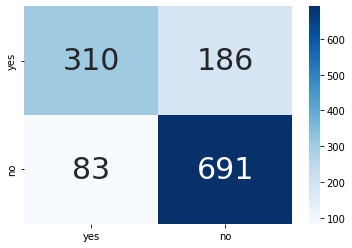

In [ ]:
labels = ['yes', 'no']
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='g', cbar=True, annot_kws={"size": 30})